In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')

df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


### Categorical Feature Analysis

At this point, we just see what variations of values each categorical feature has. One hot encoding will come later after we split the data. 

In [5]:
for x in ['card','owner','selfemp']:
    print(f'{x} column values: {df[x].unique()}')

card column values: ['yes' 'no']
owner column values: ['yes' 'no']
selfemp column values: ['no' 'yes']


In [6]:
for x in ['card','owner','selfemp']:
    print(f'{x} column value counts: \n{df[x].value_counts()}')

card column value counts: 
yes    1023
no      296
Name: card, dtype: int64
owner column value counts: 
no     738
yes    581
Name: owner, dtype: int64
selfemp column value counts: 
no     1228
yes      91
Name: selfemp, dtype: int64


Map target column, `card`, to encoded value, 1 and 0.

In [15]:
for x in ['card']:
    df[x] = np.where(df[x] == 'yes', 1, 0)

In [16]:
for x in ['card']:
    print(f'{x} column value counts: \n{df[x].value_counts()}')

card column value counts: 
1    1023
0     296
Name: card, dtype: int64


### Dataset Splitting

In [17]:
# Split dataset to training and test. Size of test test is 0.2
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
# Split training dataset to train and validation set with ratio 3:1
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# Reset index for three sets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Assigning values of `card` column of each set as target
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

# Remove `card` column from each set
del df_train['card']
del df_val['card']
del df_test['card']

#### Question 1

Which numerical variable (among the following 4) has the highest AUC?

In [18]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

numerical = ["age", "income", "share", "reports",
              "expenditure", "dependents", "months", 
              "majorcards", "active"]

# Create a dict to store pairs of feature with auc score
dict_auc = dict()

for x in numerical:
    auc = roc_auc_score(y_train, df_train[x])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[x])
    # Assign key to dict along with result
    dict_auc[x] = auc
    
dict_auc

{'age': 0.5240020979407055,
 'income': 0.5908049467233478,
 'share': 0.989183643423692,
 'reports': 0.7166629860689376,
 'expenditure': 0.991042345276873,
 'dependents': 0.5327757227773791,
 'months': 0.5294217780967629,
 'majorcards': 0.5343859842838476,
 'active': 0.6043173411362006}

#### Answer: share

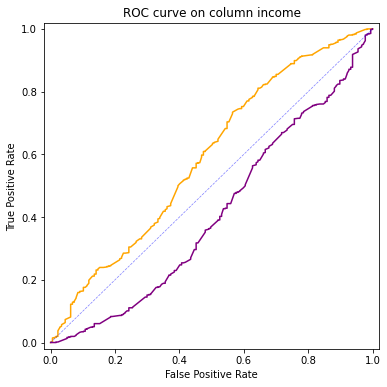

In [19]:
## Plotting ROC curve on column income

plt.figure(figsize=(6, 6))

column = 'income'

fpr, tpr, _ = roc_curve(y_train, df_train[column])
plt.plot(fpr, tpr, color='orange', label='+share')

fpr, tpr, _ = roc_curve(y_train, -df_train[column])
plt.plot(fpr, tpr, color='purple', label='-share')

plt.plot([0, 1], [0, 1], color='blue', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title(f'ROC curve on column {column}')

plt.show()

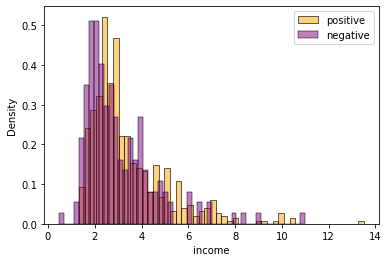

In [20]:
sns.histplot(df_train[column][y_train == 1],
            stat='density', bins=50,
            color='orange', alpha=0.5,
            label='positive')

sns.histplot(df_train[column][y_train == 0],
            stat='density', bins=50,
            color='purple', alpha=0.5,
            label='negative')
# plt.ylim([-0.02, 10])
plt.legend()
plt.show()

### Model Training

In [21]:
column_use = ["reports", "age", "income", "share", 
              "expenditure", "dependents", "months", 
              "majorcards", "active", "owner", "selfemp"]

In [22]:
# DictVectorizer
## Modify format from training dataframe to dictionary
train_dict = df_train[column_use].to_dict(orient='records')

## Using DictVectorizer to create one-hot encoding for categorical variables
dv = DictVectorizer(sparse=False)

## Fitting DictVectorizer on training dictionary
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [23]:
# Initialize LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# Fit LogisticRegression to train and target pairs
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [24]:
## Modify format from validation dataframe to dictionary
val_dict = df_val[column_use].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Predict model on validation set, returning probabilities
y_pred = model.predict_proba(X_val)[:, 1]

### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [25]:
round(roc_auc_score(y_val, y_pred), 3)

0.995

In [26]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9739783600107306

#### Answer: 0.995

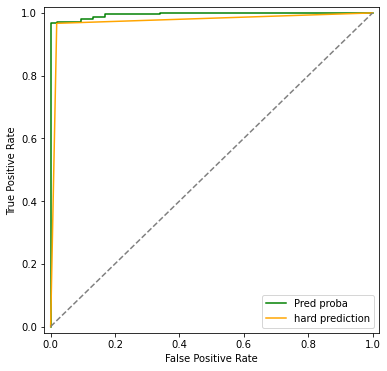

In [31]:
# Plotting prediction results on both probabilistic binary and hard binary with ROC curve

plt.figure(figsize=(6, 6))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, color='green', label='Pred proba')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, color='orange', label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Question 3

At which threshold precision and recall curves intersect?

In [32]:
def tpr_fpr_dataframe(y_val, y_pred):
    """
    Generate dataframe filled with # prediction correct/incorrect 
        vs validation respecting to threshold
    """
    scores = list()

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'] )
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'] )
    
    return df_scores

In [33]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,211,53,0,0,1.000000,1.000000
10,0.1,210,17,1,36,0.995261,0.320755
20,0.2,207,5,4,48,0.981043,0.094340
30,0.3,205,5,6,48,0.971564,0.094340
40,0.4,205,1,6,52,0.971564,0.018868
50,0.5,204,1,7,52,0.966825,0.018868
60,0.6,204,1,7,52,0.966825,0.018868
70,0.7,204,1,7,52,0.966825,0.018868
80,0.8,204,1,7,52,0.966825,0.018868
90,0.9,204,0,7,53,0.966825,0.000000


In [34]:
df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])

In [35]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.0,211,53,0,0,1.000000,1.000000,0.799242,1.000000
10,0.1,210,17,1,36,0.995261,0.320755,0.925110,0.995261
20,0.2,207,5,4,48,0.981043,0.094340,0.976415,0.981043
30,0.3,205,5,6,48,0.971564,0.094340,0.976190,0.971564
40,0.4,205,1,6,52,0.971564,0.018868,0.995146,0.971564
50,0.5,204,1,7,52,0.966825,0.018868,0.995122,0.966825
60,0.6,204,1,7,52,0.966825,0.018868,0.995122,0.966825
70,0.7,204,1,7,52,0.966825,0.018868,0.995122,0.966825
80,0.8,204,1,7,52,0.966825,0.018868,0.995122,0.966825
90,0.9,204,0,7,53,0.966825,0.000000,1.000000,0.966825


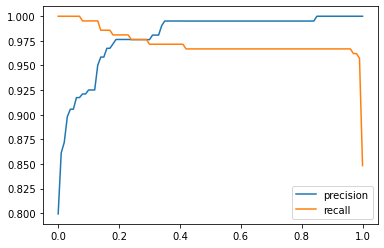

In [36]:
plt.plot(df_scores['threshold'], df_scores['precision'], label='precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='recall')

plt.legend()
plt.show()

#### Answer: 0.3

### Question 4

At which threshold F1 is maximal?

In [37]:
df_scores['f1_score'] = 2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1_score
0,0.0,211,53,0,0,1.000000,1.000000,0.799242,1.000000,0.888421
10,0.1,210,17,1,36,0.995261,0.320755,0.925110,0.995261,0.958904
20,0.2,207,5,4,48,0.981043,0.094340,0.976415,0.981043,0.978723
30,0.3,205,5,6,48,0.971564,0.094340,0.976190,0.971564,0.973872
40,0.4,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
50,0.5,204,1,7,52,0.966825,0.018868,0.995122,0.966825,0.980769
60,0.6,204,1,7,52,0.966825,0.018868,0.995122,0.966825,0.980769
70,0.7,204,1,7,52,0.966825,0.018868,0.995122,0.966825,0.980769
80,0.8,204,1,7,52,0.966825,0.018868,0.995122,0.966825,0.980769
90,0.9,204,0,7,53,0.966825,0.000000,1.000000,0.966825,0.983133


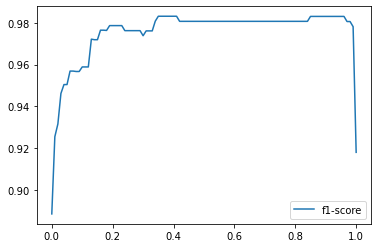

In [38]:
plt.plot(df_scores['threshold'], df_scores['f1_score'], label='f1-score')

plt.legend()
plt.show()

#### Answer: 0.4

### Question 5

How large is standard devidation of the AUC scores across different folds?

In [39]:
def train(df, y, C=1.0):
    cat = df[column_use].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[column_use].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [40]:
from sklearn.model_selection import KFold

# Initialize kFold to produce different prediction results of different folds
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
aucs = []

# Indexes made from kFold will be used for setting up different folds of with random index rows
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.card.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [43]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.996 ± 0.003


#### Answer: 0.003

### Question 6 

Which C leads to the best mean score?

In [44]:
def train(df, y, C):
    cat = df[column_use].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [45]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.992 ± 0.006
C=0.1, auc = 0.995 ± 0.004
C=1, auc = 0.996 ± 0.003
C=10, auc = 0.996 ± 0.003


#### Answer: 10